In [119]:
import os

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import calendar

import datetime
plt.style.use('ggplot')

# Modeling concentration of PM2.5 across counties in California

__[Particulate matter (PM)](https://www.epa.gov/pm-pollution/particulate-matter-pm-basics)__ refers to tiny particles of solid or liquid suspended in the air. Particles with a diameter of 2.5 micrometers or smaller (PM2.5) are __[particularly concerning](https://ww2.arb.ca.gov/resources/inhalable-particulate-matter-and-health)__ because they can reach deep into the lungs and even the bloodstream. Exposure to PM2.5 has been linked to stroke, cardiovascular and respiratory disease, cancer, and other serious health outcomes. 

While daily concentrations above 35 μg/m³ are considered extremely hazardous, there is no known safe level of PM2.5 exposure.

PM2.5 comes from a wide range of sources, either emitted directly from vehicles, industrial activity, or fires, or formed in the atmosphere through chemical reactions involving pollutants like sulfur dioxide or nitrogen oxides. In California, wildfires are a major source. Ash and smoke contain __[high levels of PM2.5](https://www.epa.gov/wildfire-smoke-course/why-wildfire-smoke-health-concern)__, and wildfire events have become more frequent and intense with climate change.

In this notebook, we’ll build Bayesian hierarchical models to predict average monthly PM2.5 concentrations at the county level in California. We will use publicly available data provided by the U.S. __[Environmental Protection Agency (EPA)](https://www.epa.gov/outdoor-air-quality-data/download-daily-data)__. Our goal is to account for spatial and temporal variation and eventually quantify uncertainty in these predictions.


### Load data

In [120]:
folder_path = '/Users/oliverastojanovic/Desktop/PSIML_2025/data/'   # change this to your folder path
dataframes = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True).sort_values(by='Date')

## Exploratory data analysis

First, we’ll do a few quick checks: are there missing values, any NaNs, anything that looks unsual. If some data is missing, we’ll have to decide whether to drop or impute. We’ll also look at the distributions of the main variables because we need that to pick a reasonable likelihood for the Bayesian model.

In [121]:
data.head()

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,Method Code,Method Description,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
329990,01/01/2019,AQS,60690002,3,2.3,ug/m3 LC,13,Hollister,1,100.0,...,170.0,Met One BAM-1020 Mass Monitor w/VSCC,41940.0,"San Jose-Sunnyvale-Santa Clara, CA",6,California,69,San Benito,36.843425,-121.362100
296724,01/01/2019,AQS,60010015,3,2.7,ug/m3 LC,15,Pleasanton - Owens Ct,1,100.0,...,170.0,Met One BAM-1020 Mass Monitor w/VSCC,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.701222,-121.903019
297076,01/01/2019,AQS,60070008,1,13.5,ug/m3 LC,59,Chico-East Avenue,1,100.0,...,145.0,R & P Model 2025 PM-2.5 Sequential Air Sampler...,17020.0,"Chico, CA",6,California,7,Butte,39.761680,-121.840470
297237,01/01/2019,AQS,60070008,3,12.5,ug/m3 LC,57,Chico-East Avenue,1,100.0,...,731.0,Met-One BAM-1020 W/PM2.5 SCC,17020.0,"Chico, CA",6,California,7,Butte,39.761680,-121.840470
297970,01/01/2019,AQS,60074001,3,5.4,ug/m3 LC,30,"TRAFFIC, RURAL PAVED ROAD",1,100.0,...,731.0,Met-One BAM-1020 W/PM2.5 SCC,17020.0,"Chico, CA",6,California,7,Butte,39.327563,-121.668811


In [122]:
data.describe()

,Site ID,POC,Daily Mean PM2.5 Concentration,Daily AQI Value,Daily Obs Count,Percent Complete,AQS Parameter Code,Method Code,CBSA Code,State FIPS Code,County FIPS Code,Site Latitude,Site Longitude
count,3.777970e+05,377797.000000,377797.000000,377797.000000,377797.000000,377797.000000,377797.000000,357761.000000,346925.000000,377797.0,377797.000000,377797.000000,377797.000000
mean,6.056779e+07,3.293610,9.025533,40.347258,1.000222,100.022234,88192.692594,330.382196,35350.940232,6.0,56.634852,36.294985,-119.673694
std,2.945780e+05,3.887029,11.977866,26.455839,0.014909,1.490949,168.408057,250.379531,9865.278873,0.0,29.455437,2.294345,2.016746
min,6.001001e+07,1.000000,-6.700000,0.000000,1.000000,100.000000,88101.000000,143.000000,12540.000000,6.0,1.000000,32.552824,-124.203470
25%,6.031000e+07,1.000000,4.100000,23.000000,1.000000,100.000000,88101.000000,170.000000,31080.000000,6.0,31.000000,34.103740,-121.493110
50%,6.063101e+07,3.000000,6.900000,38.000000,1.000000,100.000000,88101.000000,170.000000,40140.000000,6.0,63.000000,36.489470,-119.706200
75%,6.075000e+07,3.000000,10.800000,54.000000,1.000000,100.000000,88101.000000,707.000000,41860.000000,6.0,75.000000,37.962069,-118.049167
max,6.113100e+07,26.000000,824.100000,1493.000000,2.000000,200.000000,88502.000000,810.000000,49700.000000,6.0,113.000000,41.756130,-115.483070


It seems like we have some negative value in `Daily Mean PM2.5 Concentration` column, which shouldn't happen. Let's inspect those values.

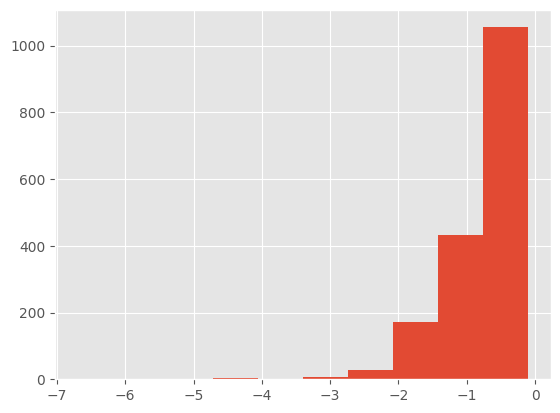

In [123]:
plt.hist(data[data["Daily Mean PM2.5 Concentration"]<0]["Daily Mean PM2.5 Concentration"])
plt.show()

Negative values usually come from equipment malfunction, and we will in this tutorial replace them with zeros.

In [124]:
data.loc[data["Daily Mean PM2.5 Concentration"] < 0, "Daily Mean PM2.5 Concentration"] = 0

In [125]:
data[data["Daily Mean PM2.5 Concentration"]<0]["Daily Mean PM2.5 Concentration"].sum() # the sum should we zero, we successfully replaced all negative values with zero

0.0

In [126]:
data.isnull().any() # there are some NaNs in the dataset, but we're lucky, we don't have any NaNs columns we will use

Date                              False
Source                            False
Site ID                           False
POC                               False
Daily Mean PM2.5 Concentration    False
Units                             False
Daily AQI Value                   False
Local Site Name                    True
Daily Obs Count                   False
Percent Complete                  False
AQS Parameter Code                False
AQS Parameter Description         False
Method Code                        True
Method Description                 True
CBSA Code                          True
CBSA Name                          True
State FIPS Code                   False
State                             False
County FIPS Code                  False
County                            False
Site Latitude                     False
Site Longitude                    False
dtype: bool

We want to fit a model on data from 2019 to 2024, and treat everything we have in 2025 as 'unseen data'. First, we need to ensure we have data for all counties during that period, as monitoring stations can sometimes go offline, be decommissioned, or fail to collect data for certain stretches of time.

In [127]:
# drop data for 2025
data['Date'] = pd.to_datetime(data['Date'])

rows_to_drop = data[data['Date'] > datetime.datetime(2024, 12, 31)].index

data = data.drop(rows_to_drop)

In [128]:
counties_list = data['County'].unique().tolist()

print("These counties have some data missing in the last 6 years:")

missing_counties = []
missing_dates_expanded = []
percentage_missing_list = [] 

# Define the expected date range for the last 6 years
start_date = "2019-01-01"
end_date = "2024-12-31"
expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')

for county in counties_list:
    county_data = data[data['County'] == county]
    
    # Ensure only unique dates are considered
    actual_dates = pd.to_datetime(county_data['Date']).drop_duplicates().sort_values()
    
    # Find missing dates by comparing expected and actual dates
    missing_dates = expected_dates.difference(actual_dates)
    
    if len(missing_dates) > 0: 
        missing_counties.append(county)
        percentage_missing = np.round((100 - len(actual_dates) / len(expected_dates) * 100), 2)
        percentage_missing_list.append({"County": county, "Percentage Missing": percentage_missing})
        
        for date in missing_dates:
            missing_dates_expanded.append({"County": county, "Missing Date": date})
        print(county, "has", percentage_missing, "% of data missing")

missing_dates_df = pd.DataFrame(missing_dates_expanded)
percentage_missing_df = pd.DataFrame(percentage_missing_list)
missing_dates_df = missing_dates_df.merge(percentage_missing_df, on="County", how="left")

These counties have some data missing in the last 6 years:
San Benito has 1.55 % of data missing
San Mateo has 5.34 % of data missing
Calaveras has 3.7 % of data missing
Colusa has 0.59 % of data missing
Contra Costa has 0.73 % of data missing
Glenn has 2.83 % of data missing
Imperial has 0.14 % of data missing
Yolo has 2.78 % of data missing
Ventura has 0.05 % of data missing
Tulare has 0.05 % of data missing
Tehama has 4.06 % of data missing
Sutter has 1.32 % of data missing
Sonoma has 8.62 % of data missing
Solano has 9.22 % of data missing
Siskiyou has 3.24 % of data missing
Santa Cruz has 0.09 % of data missing
Santa Clara has 0.18 % of data missing
Napa has 61.82 % of data missing
Orange has 0.5 % of data missing
San Francisco has 11.13 % of data missing
Mono has 4.97 % of data missing
Merced has 0.36 % of data missing
Mendocino has 0.32 % of data missing
Mariposa has 6.71 % of data missing
Marin has 1.55 % of data missing
Madera has 2.65 % of data missing
Del Norte has 16.83 % o

Most counties with missing dates have a very low percentage of missing data, which probably means there’s just an occasional missing date. In those cases, we can impute average values.

However, a few counties have a substantially higher proportion of missing dates, like Napa (61.82%) or Humboldt (53.6%). This likely indicates that monitoring stations went offline for an extended period. In such cases, it doesn’t make sense to impute average values. A common rule of thumb is that imputation is reasonable when less than 25% of the data is missing, although  this heavily depends on the context.

In our case, Shasta County has 25.55% missing data. That’s borderline, so we could reasonably go either way. I decided to keep it, since we're already excluding a few other counties.

In [129]:
counties_to_drop = percentage_missing_df[percentage_missing_df["Percentage Missing"] >= 26]["County"].tolist()

data = data[~data["County"].isin(counties_to_drop)].reset_index(drop=True)

remaining_counties = data["County"].unique()
print(f"Remaining counties: {len(remaining_counties)}")
print(f"Counties still in data: {remaining_counties}")

Remaining counties: 47
Counties still in data: ['San Benito' 'Alameda' 'Butte' 'San Mateo' 'Calaveras' 'Colusa'
 'San Luis Obispo' 'Contra Costa' 'Fresno' 'Glenn' 'Imperial' 'Inyo'
 'San Joaquin' 'Kern' 'Santa Barbara' 'San Bernardino' 'Yolo' 'Ventura'
 'Tulare' 'Tehama' 'Sutter' 'Stanislaus' 'Sonoma' 'Solano' 'Siskiyou'
 'Santa Cruz' 'Santa Clara' 'Kings' 'San Diego' 'Orange' 'Placer'
 'Riverside' 'Sacramento' 'Monterey' 'Los Angeles' 'San Francisco' 'Mono'
 'Merced' 'Mendocino' 'Mariposa' 'Marin' 'Madera' 'Del Norte' 'Trinity'
 'Nevada' 'Plumas' 'Shasta']


### Impute data

In [130]:
# Filter out counties to drop
missing_dates_df = missing_dates_df[~missing_dates_df['County'].isin(counties_to_drop)].reset_index(drop=True)

new_rows = []

for county in missing_dates_df['County'].unique():
    county_missing_dates = missing_dates_df[missing_dates_df['County'] == county]['Missing Date']
    
    # Get a sample row for the county to copy other column values
    sample_row = data[data['County'] == county].iloc[0].to_dict()
    
    # Calculate mean values for specific columns
    mean_values = data[data['County'] == county][['Daily Mean PM2.5 Concentration', 'Daily AQI Value', 'Daily Obs Count']].mean()

    # Create new rows for missing dates
    for missing_date in county_missing_dates:
        new_row = sample_row.copy() 
        new_row['Date'] = missing_date 
        new_row.update(mean_values.to_dict())
        new_rows.append(new_row)

data = pd.concat([data, pd.DataFrame(new_rows)], ignore_index=True)
data = data.sort_values(by=['County', 'Date']).reset_index(drop=True)

In [131]:
# Check if there are any missing dates in the entire data DataFrame
start_date = "2019-01-01"
end_date = "2024-12-31"
expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')

actual_dates = pd.to_datetime(data['Date']).drop_duplicates().sort_values()
missing_dates = expected_dates.difference(actual_dates)

if len(missing_dates) > 0:
    print(f"The dataset still has {len(missing_dates)} missing dates.")
else:
    print("The dataset has no missing dates.")

The dataset has no missing dates.


### Time-series of daily PM2.5 concentration

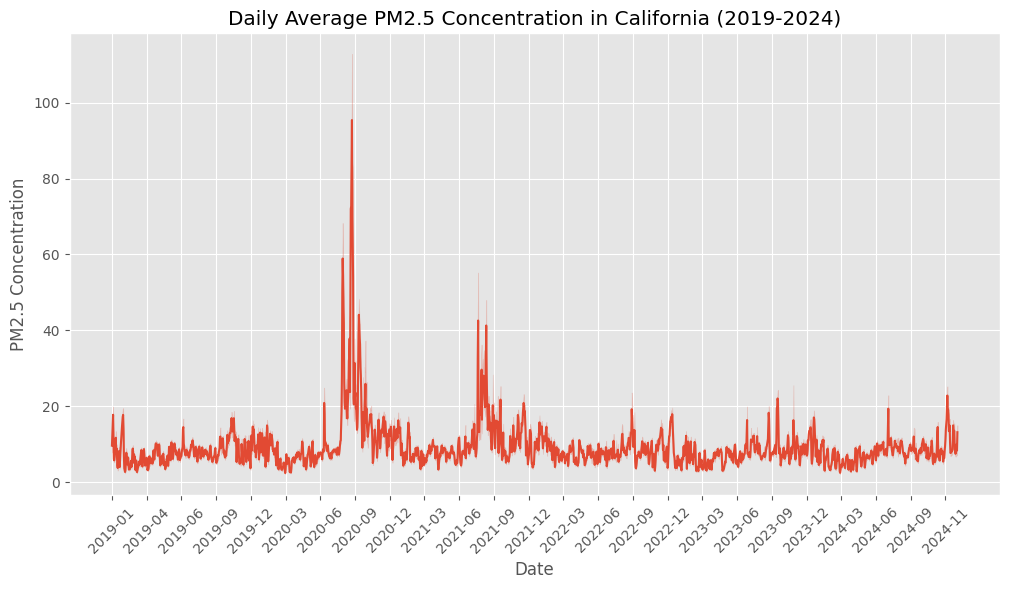

In [132]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="Date", y="Daily Mean PM2.5 Concentration")

tick_step = 90 # put ticks every 3 months
unique_dates = pd.Series(data['Date'].unique()) 
plt.xticks(ticks=unique_dates[::tick_step], 
           labels=unique_dates[::tick_step].dt.strftime('%Y-%m'), 
           rotation=45)

plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration")
plt.title("Daily Average PM2.5 Concentration in California (2019-2024)")
plt.show()

We see that on most days, daily concentration in California is around 20 μg/m³ or less. There are some big spikes in 2020 and 2021, which probably come from a big wildfire or similar extreme event.

### Does data have seasonality?

Before developing a model, we should check whether the data exhibits any seasonal patterns.

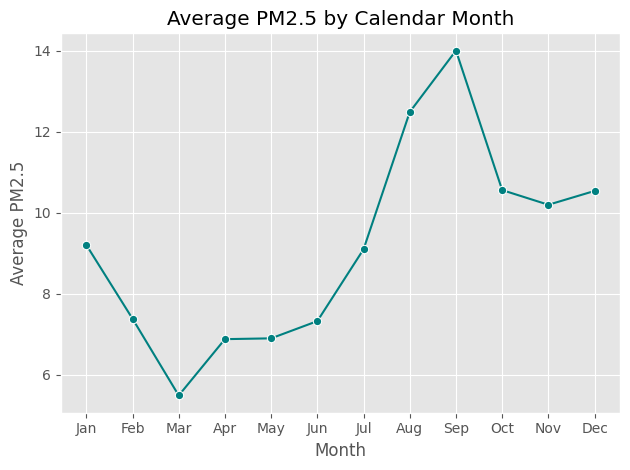

In [133]:
data["month_name"] = data["Date"].dt.strftime('%b')
data["month_num"] = data["Date"].dt.month  # for correct ordering

# Group by month number to preserve order
monthly_seasonal_avg = data.groupby("month_num")["Daily Mean PM2.5 Concentration"].mean().reset_index()

monthly_seasonal_avg["month_name"] = monthly_seasonal_avg["month_num"].apply(lambda x: calendar.month_abbr[x]) 

sns.lineplot(x='month_name', y='Daily Mean PM2.5 Concentration', data=monthly_seasonal_avg, marker='o', color='teal')
plt.title("Average PM2.5 by Calendar Month")
plt.xlabel("Month")
plt.ylabel("Average PM2.5")
plt.tight_layout()
plt.show()


We see higher average monthly concentration of PM2.5 in September and toward the end of the year and in January. 

This pattern likely reflects a combination of factors: 

* wildfire activity in late summer and fall, driven in part by strong dry winds such as the __[Santa Ana winds](https://en.wikipedia.org/wiki/Santa_Ana_winds)__ in Southern California and __[Diablo winds](https://en.wikipedia.org/wiki/Diablo_wind)__ in Northern California, which rapidly spread fires and worsen air quality

* winter pollution events like __[temperature inversions](https://www.eea.europa.eu/en/analysis/maps-and-charts/temperature-inversion-traps-pollution-at)__ and residential heating contribute to elevated PM2.5 levels in the colder months.

## Calculate monthly average

We have daily data, but for the rest of the tutorial we’ll use monthly averages. Using monthly data reduces computational load and helps the model run faster. It also smooths out short-term fluctuations, which makes it easier to focus on longer-term trends.

We will now calculate monthly average concentration of PM.2 and some variables that will help us incorproate seasonality into our model later.

In [134]:
# Sort the DataFrame by 'county' and 'year_month'and extract the first date for each county
# We know that first date everywhere should be 2019-01-01, 
# but let's do it automatically just in case one county has no data for that month 
data = data.sort_values(by=['County', 'Date'])

first_dates = data.groupby('County')['Date'].first().reset_index()
first_dates.rename(columns={'Date': 'first_date'}, inplace=True)  # Rename the column to 'first_date'

data = data.merge(first_dates, on='County', how='left')

In [135]:
# compute the total time since beginning of time-serials (in years)
# This will be later used to calculate seasonality and trend

data["time_passed_total"] = (
    data['Date'].apply(datetime.datetime.toordinal)
    -data['first_date'].apply(datetime.datetime.toordinal)
)/365.0

In [136]:
data_copy = data.copy()

data_copy['year_month'] = data_copy['Date'].dt.strftime('%Y-%m')

monthly_avg = data_copy.groupby(['County', 'year_month'])['Daily Mean PM2.5 Concentration'].mean().reset_index()

monthly_avg.rename(columns={'Daily Mean PM2.5 Concentration': 'Monthly Avg PM2.5'}, inplace=True)

first_dates = monthly_avg.groupby('County')['year_month'].first().reset_index()
first_dates.rename(columns={'year_month': 'first_date'}, inplace=True)

monthly_avg = monthly_avg.merge(first_dates, on='County', how='left')

monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'], format='%Y-%m')
monthly_avg['first_date'] = pd.to_datetime(monthly_avg['first_date'], format='%Y-%m')

# Calculate time passed in years since county's first month (for trend)
monthly_avg["time_passed_total"] = (
    monthly_avg['year_month'].apply(datetime.datetime.toordinal)
    - monthly_avg['first_date'].apply(datetime.datetime.toordinal)
) / 365.0


monthly_avg['month'] = monthly_avg['year_month'].dt.month

# Normalize month to [0,1) for seasonality
monthly_avg['month_fraction'] = (monthly_avg['month'] - 1) / 12.0

monthly_avg['county_id'] = monthly_avg['County'].astype('category').cat.codes
n_counties = monthly_avg['county_id'].nunique()

In [137]:
# this is how our new dataframe looks like
monthly_avg.head()

,County,year_month,Monthly Avg PM2.5,first_date,time_passed_total,month,month_fraction,county_id
0,Alameda,2019-01-01,9.066667,2019-01-01,0.000000,1,0.000000,0
1,Alameda,2019-02-01,4.255952,2019-01-01,0.084932,2,0.083333,0
2,Alameda,2019-03-01,5.255978,2019-01-01,0.161644,3,0.166667,0
3,Alameda,2019-04-01,7.265294,2019-01-01,0.246575,4,0.250000,0
4,Alameda,2019-05-01,6.307065,2019-01-01,0.328767,5,0.333333,0


### Plot distribution of monthly average

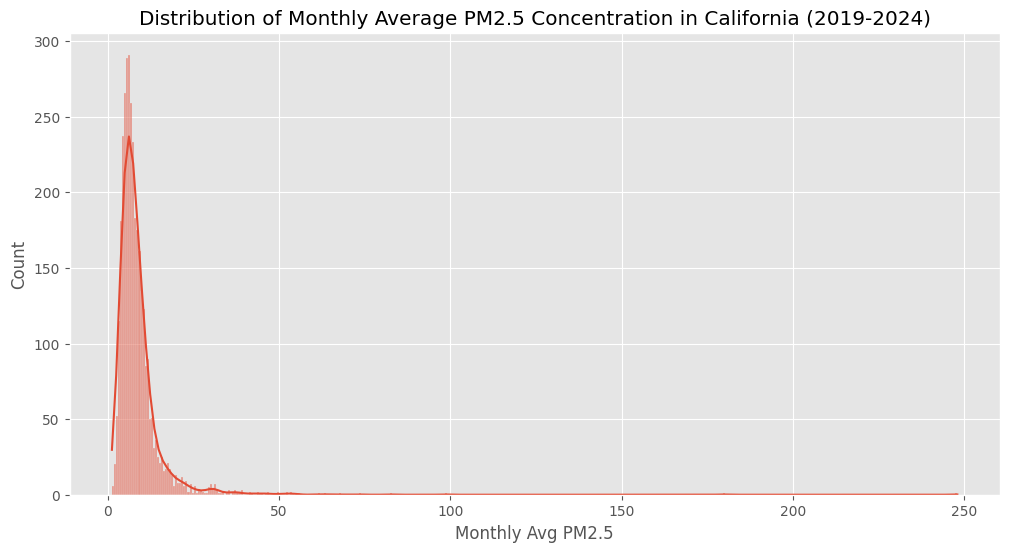

In [140]:
plt.figure(figsize=(12, 6))

sns.histplot(monthly_avg["Monthly Avg PM2.5"], kde=True)

plt.title("Distribution of Monthly Average PM2.5 Concentration in California (2019-2024)")
plt.show()

As expected, many data points are between 0 and 20. There's also a small bump between 20 and 50, and a long tail. Let's plot a distribution for a couple of counties to get a better sense of data.

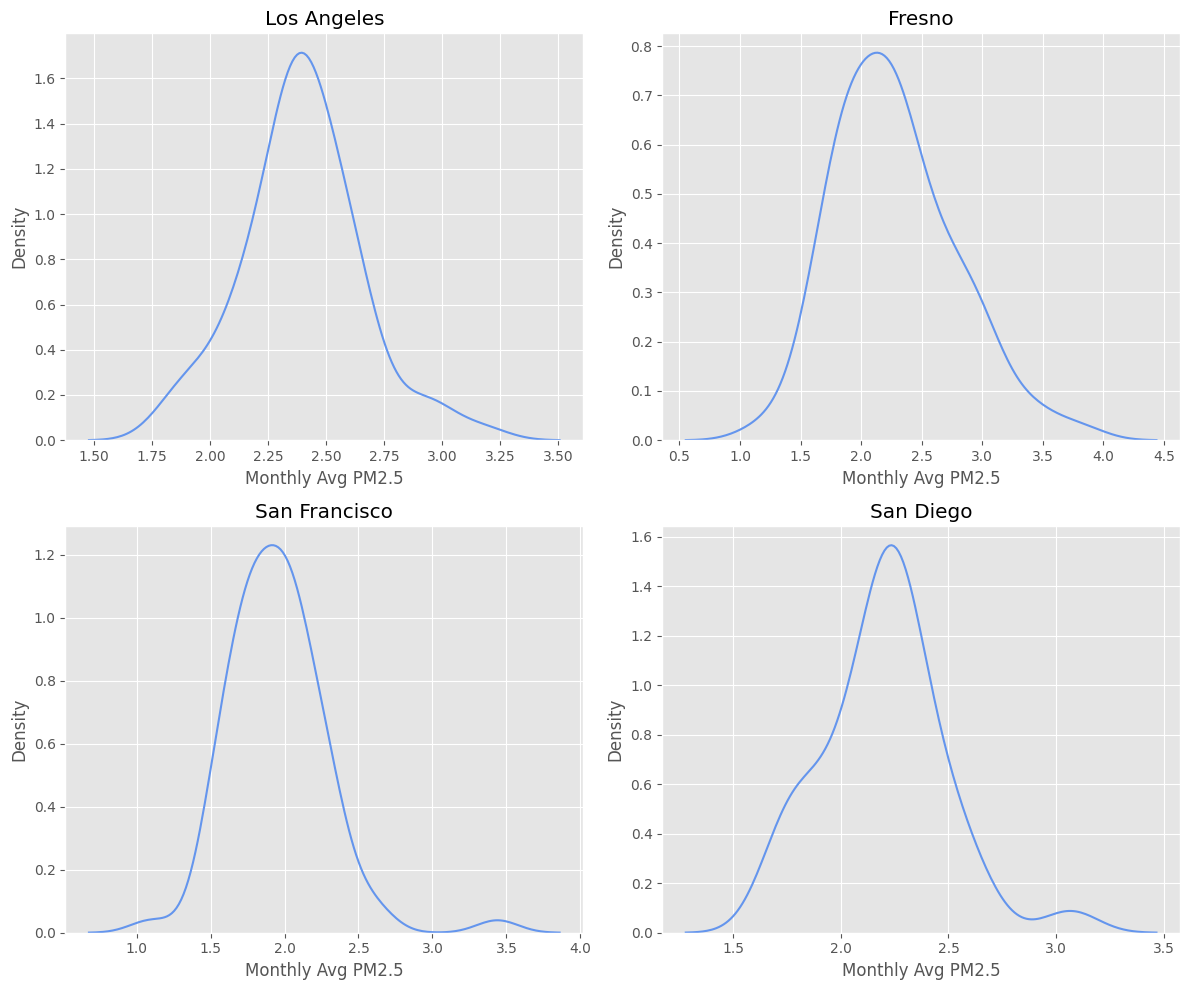

In [81]:
counties = ['Los Angeles', 'Fresno', 'San Francisco', 'San Diego']


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, county in zip(axes.flatten(), counties):
    county_data = monthly_avg[monthly_avg['County'] == county]
    sns.kdeplot(np.log(county_data['Monthly Avg PM2.5']), color='cornflowerblue', ax=ax)
    ax.set_title(county)
    ax.set_xlabel('Monthly Avg PM2.5')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

Looking at these distributions, it’s clear the data doesn’t follow a Normal distribution. It looks like it might be bimodal. It's probably a mix of two distributions, which would make sense. On most days PM2.5 is low, but during wildfires it can get very high.

It seems like on "good days" data follows a __[LogNormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)__ (no negative values), but bad days it probably follows a different LogNormal with a higher mean. That pattern suggests there might be some kind of threshold or shift when extreme events occur.

We will now use this information to fit a Bayesian model.

## Fitting a Bayesian hierarchical model

### Bayesian hierarchical models

__[Bayesian hierarchical models](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling)__ are a class of statistical models that involve multiple levels of parameters, allowing for the modeling of complex, structured data. They are particularly useful when data is organized in groups or layers, such as nested or repeated measurements, or when modeling different regions that share common characteristics. In these models, parameters at one level of the hierarchy depend on parameters at a higher level, facilitating the sharing of information across different groups. This approach leads to more accurate and robust inferences, especially when some groups, have limited data.

#### Markov Chain Monte Carlo sampling

__[Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)__ sampling is a set of algorithms used to approximate the posterior distribution of a model's parameters when direct computation is intractable, which is often the case with Bayesian hierarchical models. MCMC generates samples from this distribution, which can then be used to estimate summary statistics or make predictions.

### Model 1: County-hierarchy

In [85]:
with pm.Model() as model:

    # priors for seasonality
    sine = pm.math.sin(2 * np.pi * (monthly_avg["month_fraction"].values % 1))
    cosine = pm.math.cos(2 * np.pi * (monthly_avg["month_fraction"].values % 1))

    w_s = pm.Normal("w_s", mu=0, sigma=1)
    w_c = pm.Normal("w_c", mu=0, sigma=1)

    seasonality = sine * w_s + cosine * w_c

    # priors for intercept
    intercept_mu = pm.Normal("intercept_mu", mu=0, sigma=5)  # wide prior on mean
    
    intercept_offset = pm.Normal("intercept_offset", mu=0, sigma=1, shape=n_counties)
    intercept_raw = intercept_mu + intercept_offset
    
    intercept = intercept_raw[monthly_avg['county_id']]

    # create a binary variable for extreme values
    p_is_extreme = pm.Beta("p_is_extreme", alpha=1, beta=100) 
    is_extreme = pm.Bernoulli("is_extreme", p_is_extreme, shape=monthly_avg.shape[0])  

    # calculate the expected value of the response variable
    mu_base = intercept + seasonality #+ trend
    mu_extreme = pm.Normal("mu_extreme", mu=5, sigma=1)
    mu = pm.math.switch(is_extreme, mu_extreme, mu_base)

    sigma_base = pm.HalfCauchy("sigma_base", beta=1)  # prior for the standard deviation
    sigma_extreme = pm.HalfCauchy("sigma_extreme", beta=1)  # prior for the standard deviation
    sigma = pm.math.switch(is_extreme, sigma_extreme, sigma_base)

    # likelihood
    Y = pm.LogNormal("Y", 
                    mu=mu, 
                    sigma=sigma, 
                    observed=monthly_avg['Monthly Avg PM2.5'])

    trace = pm.sample(1000, tune=500, chains=4, cores=4, return_inferencedata=True)

    pm.compute_log_likelihood(trace)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [w_s, w_c, intercept_mu, intercept_offset, p_is_extreme, mu_extreme, sigma_base, sigma_extreme]
>BinaryGibbsMetropolis: [is_extreme]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 383 seconds.
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 939 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [86]:
with pm.Model() as model_negative_trend:

    # priors for seasonality
    sine = pm.math.sin(2 * np.pi * (monthly_avg["month_fraction"].values % 1))
    cosine = pm.math.cos(2 * np.pi * (monthly_avg["month_fraction"].values % 1))

    w_s = pm.Normal("w_s", mu=0, sigma=1)
    w_c = pm.Normal("w_c", mu=0, sigma=1)

    seasonality = sine * w_s + cosine * w_c

    # priors for intercept
    intercept_mu = pm.Normal("intercept_mu", mu=0, sigma=5)  # wide prior on mean
    
    intercept_offset = pm.Normal("intercept_offset", mu=0, sigma=1, shape=n_counties)
    intercept_raw = intercept_mu +  intercept_offset
    
    intercept = intercept_raw[monthly_avg['county_id']]

    # priors for trend
    mu_trend = pm.Normal("mu_trend", mu=-1, sigma=5)  # wide prior on mean

    trend_offset = pm.Normal("trend_offset", mu=0, sigma=0.5, shape=n_counties)
    weight_trend = mu_trend + trend_offset
    #
    trend = weight_trend[monthly_avg['county_id']] * monthly_avg["time_passed_total"].values

    # create a binary variable for extreme values
    p_is_extreme = pm.Beta("p_is_extreme", alpha=1, beta=100)
    is_extreme = pm.Bernoulli("is_extreme", p_is_extreme, shape=monthly_avg.shape[0])  

    # calculate the expected value of the response variable
    mu_base = intercept + seasonality + trend
    mu_extreme = pm.Normal("mu_extreme", mu=5, sigma=1)
    mu = pm.math.switch(is_extreme, mu_extreme, mu_base)

    sigma_base = pm.HalfCauchy("sigma_base", beta=1)  # prior for the standard deviation
    sigma_extreme = pm.HalfCauchy("sigma_extreme", beta=1)  # prior for the standard deviation
    sigma = pm.math.switch(is_extreme, sigma_extreme, sigma_base)

    # likelihood
    Y = pm.LogNormal("Y", 
                    mu=mu, 
                    sigma=sigma, 
                    observed=monthly_avg['Monthly Avg PM2.5'])

    trace_negative_trend = pm.sample(1000, tune=500, chains=4, cores=4, return_inferencedata=True)

    pm.compute_log_likelihood(trace_negative_trend)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [w_s, w_c, intercept_mu, intercept_offset, mu_trend, trend_offset, p_is_extreme, mu_extreme, sigma_base, sigma_extreme]
>BinaryGibbsMetropolis: [is_extreme]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 609 seconds.
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [87]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [88]:
model

             w_s ~ Normal(0, 1)
             w_c ~ Normal(0, 1)
    intercept_mu ~ Normal(0, 5)
intercept_offset ~ Normal(0, 1)
    p_is_extreme ~ Beta(1, 100)
      is_extreme ~ Bernoulli(p_is_extreme)
      mu_extreme ~ Normal(5, 1)
      sigma_base ~ HalfCauchy(0, 1)
   sigma_extreme ~ HalfCauchy(0, 1)
               Y ~ LogNormal(f(is_extreme, mu_extreme, intercept_offset, w_c, w_s, intercept_mu), f(is_extreme, sigma_extreme, sigma_base))

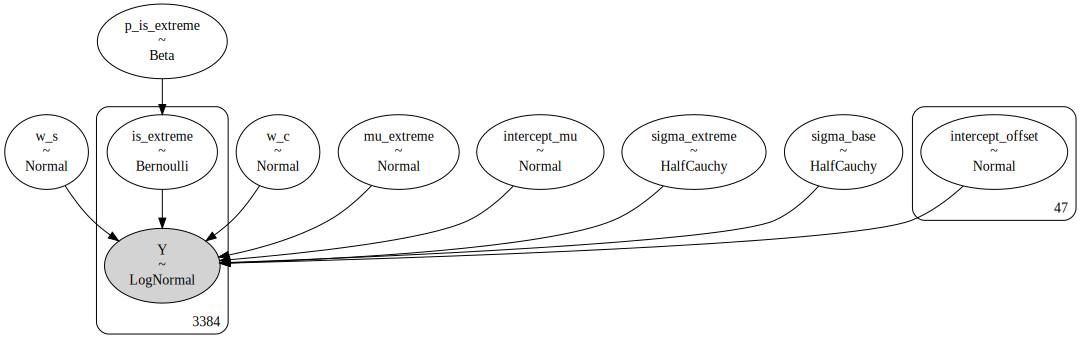

In [89]:
pm.model_to_graphviz(model)

### Convergence checks

The R-hat statistic, also known as the __[Gelman-Rubin diagnostic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic)__, is used to assess the convergence of MCMC chains. It compares the variance within each chain to the variance between chains. If the chains have converged, the within-chain variance should be similar to the between-chain variance, and R-hat should be close to 1. An R-hat value significantly greater than 1.01 indicates that the chains have not yet converged, suggesting that more iterations may be needed to obtain reliable estimates from the MCMC sampling.

In [111]:
# Inspect results
az.summary(trace, var_names=['w_s', 'w_c', 'intercept_mu', 'intercept_offset', 'mu_extreme', 'sigma_base', 'sigma_extreme'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_s,-0.242,0.008,-0.257,-0.227,0.001,0.000,103.0,1449.0,1.03
w_c,0.036,0.009,0.020,0.052,0.002,0.000,24.0,301.0,1.11
intercept_mu,2.049,0.205,1.729,2.343,0.090,0.031,6.0,16.0,1.96
intercept_offset[0],-0.035,0.208,-0.371,0.284,0.090,0.031,6.0,16.0,1.82
intercept_offset[1],-0.179,0.211,-0.505,0.149,0.092,0.031,6.0,18.0,1.87
intercept_offset[2],-0.267,0.212,-0.597,0.075,0.092,0.032,6.0,16.0,1.88
intercept_offset[3],-0.037,0.208,-0.381,0.286,0.090,0.031,6.0,15.0,1.86
intercept_offset[4],0.001,0.207,-0.336,0.325,0.090,0.030,6.0,17.0,1.84
intercept_offset[5],-0.320,0.212,-0.646,0.006,0.093,0.032,6.0,15.0,1.88
intercept_offset[6],0.173,0.215,-0.164,0.494,0.094,0.032,6.0,16.0,1.86


In [112]:
az.summary(trace_negative_trend, var_names=['w_s', 'w_c', 'intercept_mu', 'intercept_offset', 'mu_extreme', 'sigma_base', 'sigma_extreme'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_s,-0.252,0.009,-0.267,-0.235,0.000,0.000,2062.0,2168.0,1.00
w_c,0.031,0.008,0.016,0.047,0.000,0.000,1948.0,2296.0,1.00
intercept_mu,2.028,0.155,1.760,2.316,0.016,0.008,91.0,203.0,1.04
intercept_offset[0],0.073,0.170,-0.237,0.375,0.016,0.007,111.0,277.0,1.03
intercept_offset[1],-0.058,0.172,-0.379,0.263,0.017,0.007,110.0,284.0,1.03
intercept_offset[2],-0.129,0.173,-0.463,0.177,0.017,0.008,110.0,273.0,1.03
intercept_offset[3],-0.164,0.172,-0.471,0.159,0.016,0.007,112.0,293.0,1.03
intercept_offset[4],0.030,0.174,-0.288,0.349,0.017,0.008,107.0,302.0,1.03
intercept_offset[5],-0.282,0.171,-0.613,0.023,0.016,0.008,115.0,315.0,1.03
intercept_offset[6],0.196,0.173,-0.127,0.505,0.016,0.006,119.0,368.0,1.03


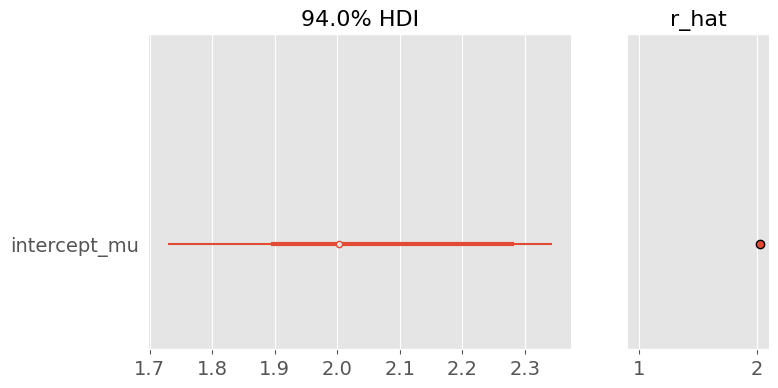

In [91]:
az.plot_forest(trace, var_names=['intercept_mu'], combined=True, r_hat=True)
plt.show()

### Posterior distributions and sampled values of each parameter

In [92]:
#az.plot_trace(trace, compact=True)
#plt.tight_layout()

This figure displays the posterior distributions of parameters (left) and the corresponding autocorrelation plots (right) for parameters **c, alpha, w_s and w_c.** The posterior distributions illustrate the range of parameter values after sampling, with **different colors representing the different counties.** The autocorrelation plots on the right assess the efficiency and convergence of the MCMC sampling, where lower autocorrelation indicates more efficient sampling. **Different dashed line styles represent the different chains** used during sampling, helping to verify that the chains have converged to a similar distribution.

### Generating predictions based on posterior distribution of the model

In [93]:
posterior_predictive = pm.sample_posterior_predictive(trace, model=model)

# Extract posterior predictive samples
ppc_samples = posterior_predictive.posterior_predictive['Y'].values

Sampling: [Y]


Output()

In [94]:
posterior_predictive_negative_trend = pm.sample_posterior_predictive(trace_negative_trend, model=model_negative_trend)

# Extract posterior predictive samples
ppc_samples_negative_trend = posterior_predictive_negative_trend.posterior_predictive['Y'].values

Sampling: [Y]


Output()

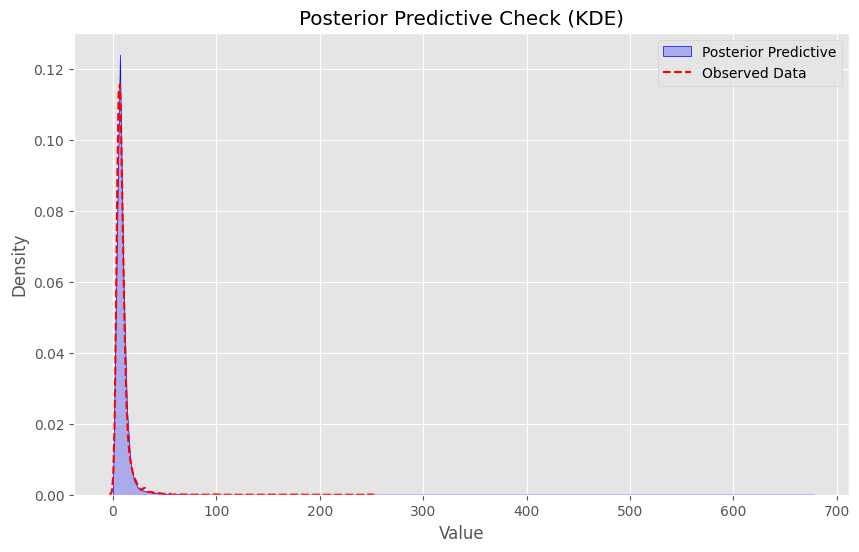

In [95]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ppc_samples.flatten(), label='Posterior Predictive', color='blue', fill=True)
sns.kdeplot(monthly_avg['Monthly Avg PM2.5'], label='Observed Data', color='red', linestyle='--')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior Predictive Check (KDE)')
plt.legend()
plt.show()

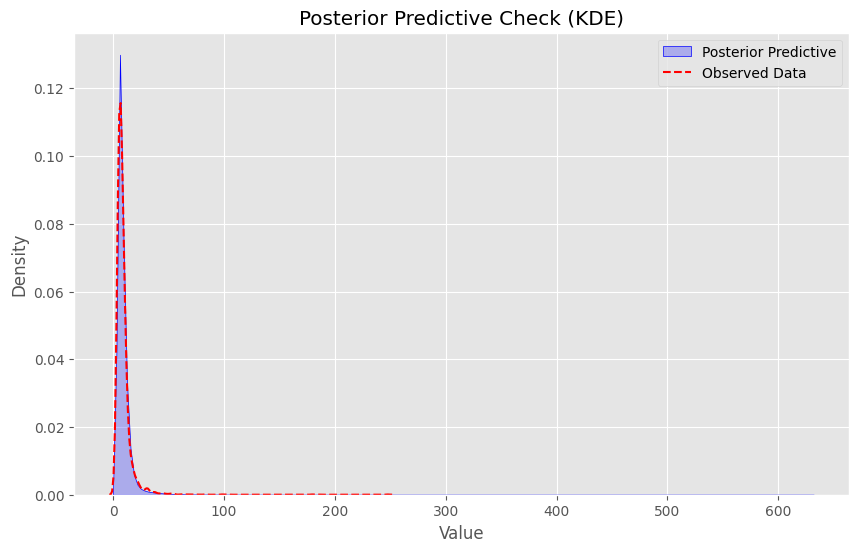

In [96]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ppc_samples_negative_trend.flatten(), label='Posterior Predictive', color='blue', fill=True)
sns.kdeplot(monthly_avg['Monthly Avg PM2.5'], label='Observed Data', color='red', linestyle='--')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior Predictive Check (KDE)')
plt.legend()
plt.show()

**Figure 4:** This figure visually compares the distribution of model-predicted values (purple shade) with the actual observed data (dashed red line). The comparison is based on predictions derived from the model's posterior distribution, checked against the observed data to assess consistency. The misalignment between the two distributions at their peaks and tails suggests that the model may have difficulty accurately predicting certain data points, i.e. outliers.

### Compute predictions

We will compute the mean of the posterior predictive samples to obtain predictions and calculate percentiles from these samples to represent prediction uncertainty. Although the Bayesian approach also allows for determining credible intervals for model parameters to assess their uncertainty, I will focus on using percentiles of the predictions for easier data visualization.

In [97]:
predicted_means = np.mean(np.mean(ppc_samples, axis=0), axis=0) #average over chains and samples
monthly_avg["predicted_means"] = predicted_means
monthly_avg["is_extreme"] = trace.posterior["is_extreme"].mean(dim=["chain", "draw"]).values

lower_bound = np.percentile(np.mean(ppc_samples, axis=0), 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(np.mean(ppc_samples, axis=0), 97.5, axis=0)  # 97.5th percentile

monthly_avg["lower_bound"] = lower_bound
monthly_avg["upper_bound"] = upper_bound

In [98]:
predicted_means.shape

(3384,)

In [99]:
predicted_means_negative_trend = np.mean(np.mean(ppc_samples_negative_trend, axis=0), axis=0) #average over chains and samples
monthly_avg["predicted_means_negative_trend"] = predicted_means_negative_trend
monthly_avg["is_extreme"] = trace_negative_trend.posterior["is_extreme"].mean(dim=["chain", "draw"]).values

lower_bound_negative_trend = np.percentile(np.mean(ppc_samples_negative_trend, axis=0), 2.5, axis=0)  # 2.5th percentile
upper_bound_negative_trend = np.percentile(np.mean(ppc_samples_negative_trend, axis=0), 97.5, axis=0)  # 97.5th percentile

monthly_avg["lower_bound_negative_trend"] = lower_bound_negative_trend
monthly_avg["upper_bound_negative_trend"] = upper_bound_negative_trend

### Calculate r2

In [100]:
r2_scores = {}

for region_id in monthly_avg['county_id'].unique():
    group = monthly_avg[monthly_avg['county_id'] == region_id]
    y_obs = group['Monthly Avg PM2.5'].values
    y_pred = group['predicted_means_negative_trend'].values
    county_name = group['County'].iloc[0]
    r2_scores[county_name] = r2_score(y_obs, y_pred)

for county_name, r2 in r2_scores.items():
    print(f'R-squared for {county_name}: {r2}')

R-squared for Alameda: 0.7121814052762407
R-squared for Butte: 0.8487632250172992
R-squared for Calaveras: 0.875592874296615
R-squared for Colusa: 0.853658035647925
R-squared for Contra Costa: 0.6534507489269477
R-squared for Del Norte: 0.5531096909701247
R-squared for Fresno: 0.76569443710087
R-squared for Glenn: 0.8263050582927778
R-squared for Imperial: -0.010078250273357625
R-squared for Inyo: 0.7361111153927474
R-squared for Kern: 0.6697671550225204
R-squared for Kings: 0.5834178912409249
R-squared for Los Angeles: 0.28806038722319494
R-squared for Madera: 0.7452137357676136
R-squared for Marin: 0.5557871789357313
R-squared for Mariposa: 0.5254912914231964
R-squared for Mendocino: 0.7430201192525995
R-squared for Merced: 0.7411682779833488
R-squared for Mono: 0.32533115840108506
R-squared for Monterey: 0.4217445260959637
R-squared for Nevada: 0.8330874243568971
R-squared for Orange: 0.45137595841399614
R-squared for Placer: 0.8740826780472654
R-squared for Plumas: 0.60016212209191

In [101]:
r2_scores = {}

for region_id in monthly_avg['county_id'].unique():
    group = monthly_avg[monthly_avg['county_id'] == region_id]
    y_obs = group['Monthly Avg PM2.5'].values
    y_pred = group['predicted_means'].values
    county_name = group['County'].iloc[0]
    r2_scores[county_name] = r2_score(y_obs, y_pred)

for county_name, r2 in r2_scores.items():
    print(f'R-squared for {county_name}: {r2}')

R-squared for Alameda: 0.7098936559541399
R-squared for Butte: 0.8391804309285146
R-squared for Calaveras: 0.8729785610572574
R-squared for Colusa: 0.8473110055356519
R-squared for Contra Costa: 0.6572050825034995
R-squared for Del Norte: 0.5281930714794147
R-squared for Fresno: 0.7623684526666602
R-squared for Glenn: 0.8197059351640765
R-squared for Imperial: -0.07872564587634079
R-squared for Inyo: 0.7430324750667276
R-squared for Kern: 0.678568339936139
R-squared for Kings: 0.5901611871391584
R-squared for Los Angeles: 0.2941065886186649
R-squared for Madera: 0.743972530340308
R-squared for Marin: 0.5102101265438378
R-squared for Mariposa: 0.5134350806943269
R-squared for Mendocino: 0.7336078725665525
R-squared for Merced: 0.7257459480325196
R-squared for Mono: 0.32036486477973825
R-squared for Monterey: 0.4920291424284733
R-squared for Nevada: 0.8210024836541846
R-squared for Orange: 0.44998515960401597
R-squared for Placer: 0.864862577958172
R-squared for Plumas: 0.595154501800350

### Observed vs Predicted plot for each county

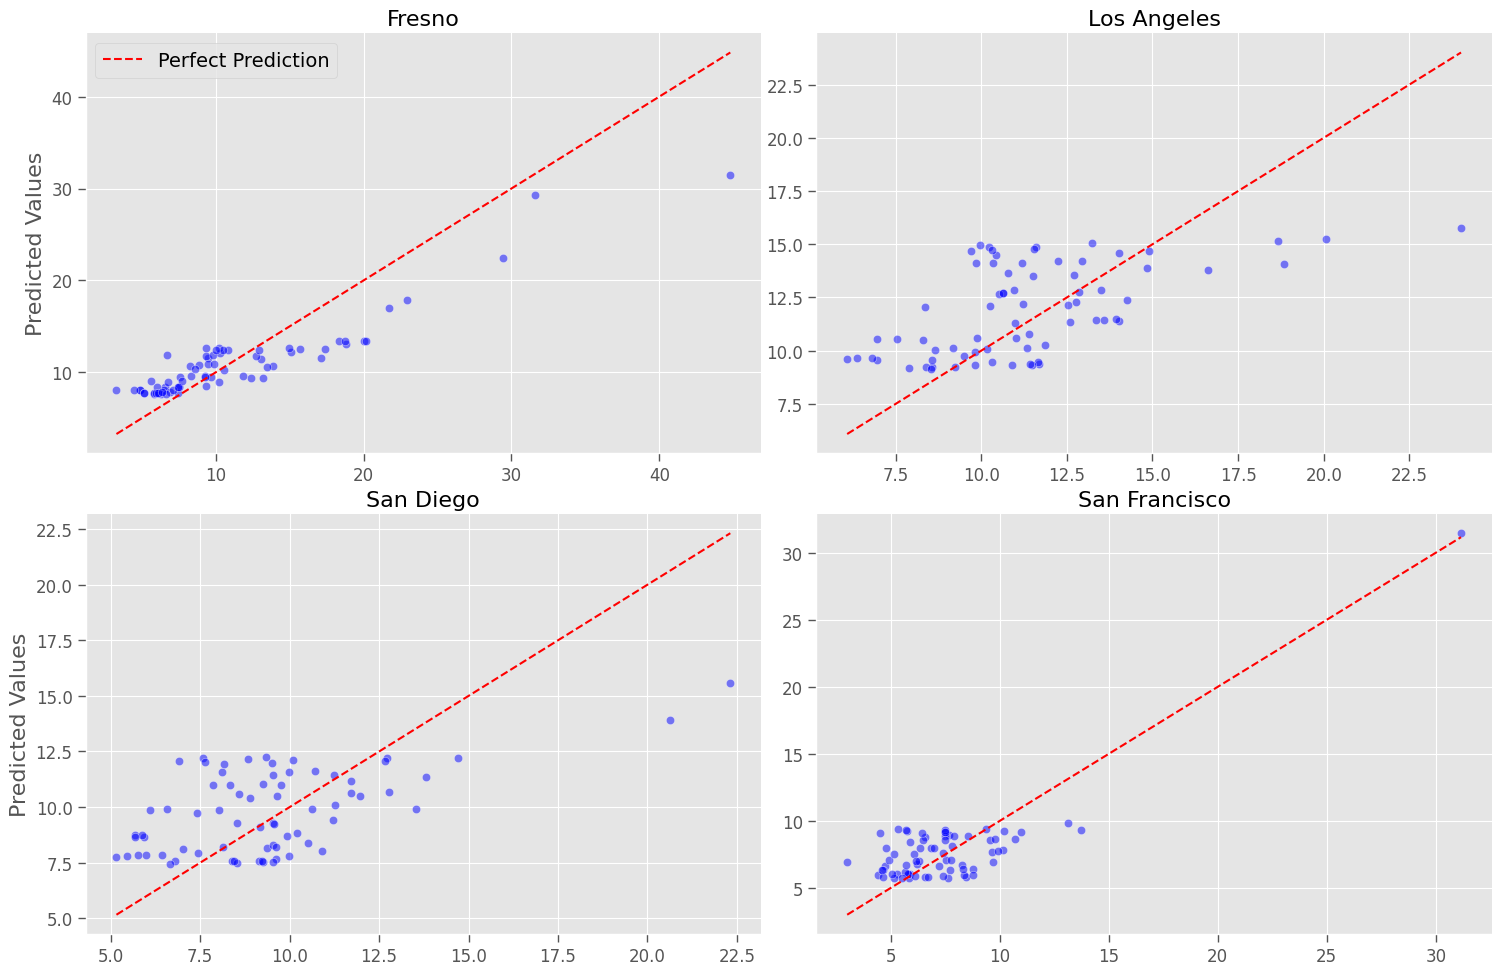

In [102]:
plot_counties = ['Los Angeles', 'Fresno', 'San Francisco', 'San Diego']

filtered_data = monthly_avg[monthly_avg['County'].isin(plot_counties)]

g = sns.FacetGrid(filtered_data, col='County', col_wrap=2, height=5, aspect=1.5, sharex=False, sharey=False)
g.map(sns.scatterplot, 'Monthly Avg PM2.5', 'predicted_means', alpha=0.5, color='blue')
g.map(sns.lineplot, 'Monthly Avg PM2.5', 'Monthly Avg PM2.5', color='red', linestyle='--', label='Perfect Prediction')

_ = [ax.set_title(title, fontsize=16) for ax, title in zip(g.axes.flat, g.col_names)]

for i, ax in enumerate(g.axes.flat):
    x_label = "Observed Values" if i == 4 or i == 5 else ''
    y_label = "Predicted Values" if i == 0 or i == 2 or i ==4 else ''
    
    ax.set_xlabel(x_label, fontsize=16 if x_label else None)
    ax.set_ylabel(y_label, fontsize=16 if y_label else None)
    
    ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)

# Add legend to the first subplot with non-empty legend handles
next((ax.legend(*ax.get_legend_handles_labels(), fontsize=14, loc='upper left', bbox_to_anchor=(0, 1))
      for ax in g.axes.flat if ax.get_legend_handles_labels()[0]), None)

**Figure 5:** This plot compares the observed data (x-axis) with the predicted values (y-axis) generated by the model for 4 regions. The diagonal red dashed line represents the line of perfect prediction. Points close to this line indicate better predictions (as in Region 1, and some points in Region 2 and 3), while scattered points (as in Region 4, and some point in Region 2 and 3) indicate more significant discrepancies between the model’s predictions and the observed data.

### Predictions for each county

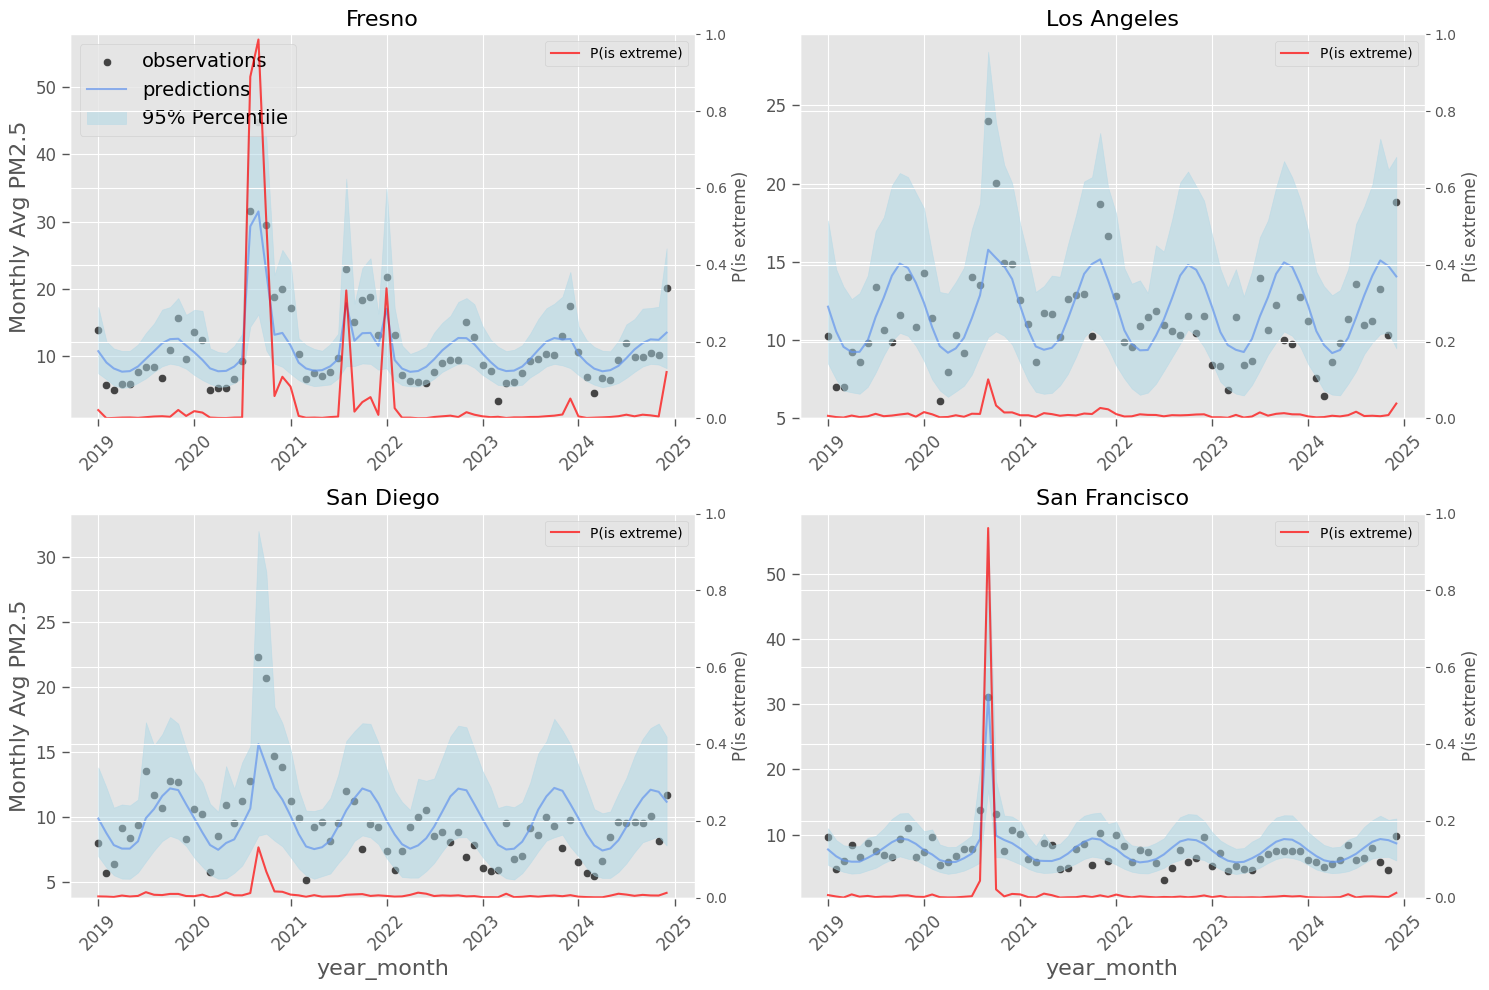

In [103]:
filtered_data = monthly_avg[monthly_avg['County'].isin(plot_counties)]

g = sns.FacetGrid(filtered_data, col='County', col_wrap=2, height=5, aspect=1.5, sharex=False, sharey=False)
g.map(sns.scatterplot, 'year_month', 'Monthly Avg PM2.5', label = 'observations', color='black', alpha=0.7)
g.map(sns.lineplot, 'year_month', 'predicted_means', label='predictions', color='cornflowerblue', alpha=0.7)

# g.map(sns.lineplot, 'year_month', 'is_extreme', label='is extreme?', color='red', alpha=0.7)

fill_patch = patches.Patch(color='lightblue', alpha=0.5, label='95% Percentile')
for ax, (region, subset) in zip(g.axes.flat, filtered_data.groupby('County')):
    ax.fill_between(subset['year_month'], 
                    subset['lower_bound'],
                    subset['upper_bound'], 
                    color='lightblue', alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.set_ylabel('P(is extreme)', fontsize=12)
    ax2.set_ylim(0, 1)
    sns.lineplot(data=subset, x='year_month', y='is_extreme', ax=ax2, color='red', alpha=0.7, label='P(is extreme)')

_ = [ax.set_title(title, fontsize=16) for ax, title in zip(g.axes.flat, g.col_names)]

for i, ax in enumerate(g.axes.flat):
    x_label = 'year_month' if i == 2 or i == 3 else ''
    y_label = 'Monthly Avg PM2.5' if i == 0 or i == 2 else ''
    
    ax.set_xlabel(x_label, fontsize=16 if x_label else None)
    ax.set_ylabel(y_label, fontsize=16 if y_label else None)
    
    ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
    ax.tick_params(axis='x', rotation=45)
    
first_ax = g.axes.flat[0]  # Access the first subplot
handles, labels = first_ax.get_legend_handles_labels()
handles.append(fill_patch)  # Add the fill color patch
labels.append('95% Percentile')  # Add label for the fill color
first_ax.legend(handles, labels, fontsize=14, loc='upper left', bbox_to_anchor=(0, 1))
    
plt.tight_layout()

**Figure 6:** Observed data (black dots) and predictions (blue lines) are shown for four regions. The shaded areas represent the 5%-95% percentiles of the predictions, indicating the uncertainty range. The model fits Region 1 the best. For Regions 2 and 3, overestimation of data points tends to occur as the effects of seasonality decrease. The model also performs well for Region 4. Although it occasionally overestimates data points, the discrepancies are relatively minor.

## Model 2: No hierarchy

In [104]:
with pm.Model() as model_no_hierarchy:

    # priors for seasonality
    sine = pm.math.sin(2 * np.pi * (monthly_avg["month_fraction"].values % 1))
    cosine = pm.math.cos(2 * np.pi * (monthly_avg["month_fraction"].values % 1))

    w_s = pm.Normal("w_s", mu=0, sigma=1)
    w_c = pm.Normal("w_c", mu=0, sigma=1)

    seasonality = sine * w_s + cosine * w_c

    # priors for intercept
    intercept_mu = pm.Normal("intercept_mu", mu=0, sigma=5)  # wide prior on mean
    
    intercept_offset = pm.Normal("intercept_offset", mu=0, sigma=1)
    intercept = intercept_mu +  intercept_offset

    # create a binary variable for extreme values
    p_is_extreme = pm.Beta("p_is_extreme", alpha=1, beta=50)
    is_extreme = pm.Bernoulli("is_extreme", p_is_extreme, shape=monthly_avg.shape[0])  
    #is_extreme = monthly_avg['Monthly Avg PM2.5'].values > cutoff

    # calculate the expected value of the response variable
    mu_base = intercept + seasonality
    mu_extreme = pm.Normal("mu_extreme", mu=5, sigma=5)
    mu = pm.math.switch(is_extreme, mu_extreme, mu_base)

    sigma_base = pm.HalfCauchy("sigma_base", beta=1)  # prior for the standard deviation
    sigma_extreme = pm.HalfCauchy("sigma_extreme", beta=1)  # prior for the standard deviation
    sigma = pm.math.switch(is_extreme, sigma_extreme, sigma_base)

    # likelihood
    Y = pm.LogNormal("Y", 
                    mu=mu, 
                    sigma=sigma, 
                    observed=monthly_avg['Monthly Avg PM2.5'])

    trace_no_hierarchy = pm.sample(1000, tune=500, chains=4, cores=4, return_inferencedata=True)

    pm.compute_log_likelihood(trace_no_hierarchy)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [w_s, w_c, intercept_mu, intercept_offset, p_is_extreme, mu_extreme, sigma_base, sigma_extreme]
>BinaryGibbsMetropolis: [is_extreme]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 464 seconds.
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

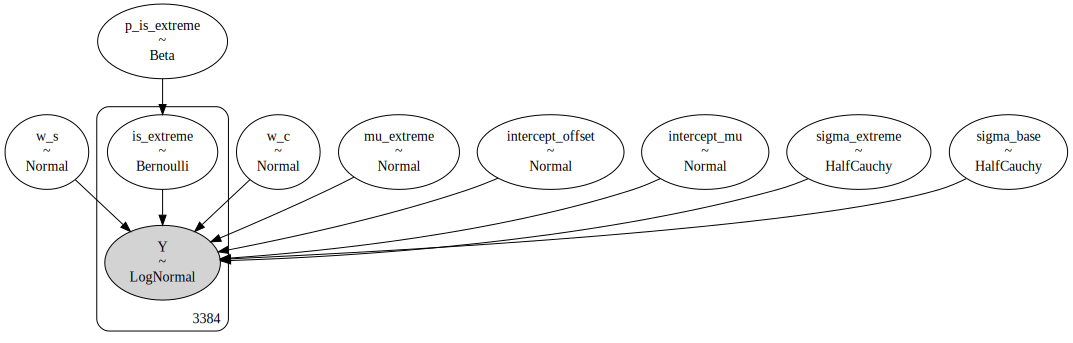

In [105]:
pm.model_to_graphviz(model_no_hierarchy)

# Model comparison

In [113]:
compare_df = az.compare({"model": trace, 
                         "model_no_hierarchy": trace_no_hierarchy, 
                         "model_negative_trend": trace_negative_trend}, 
                         ic='loo', 
                         method = 'stacking')
display(compare_df)


/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/predict-demand/lib

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_negative_trend,0,-8109.268277,370.740573,0.000000,6.627612e-01,64.280896,0.000000,True,log
model,1,-8136.250418,328.042159,26.982141,3.372388e-01,64.137937,13.454998,True,log
model_no_hierarchy,2,-8876.742594,293.337776,767.474317,3.861356e-13,64.500205,37.326973,True,log


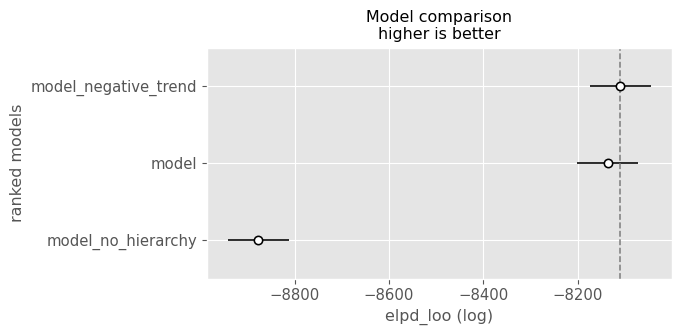

In [114]:
az.plot_compare(compare_df)
plt.show()

### Exploration of khat values

In [108]:
#loo_result = az.loo(trace_with_additional_hierarchy, pointwise=True)
#az.plot_khat(loo_result, figsize=(10, 6))

In [109]:
## Extract Pareto k values
#pareto_k = loo_result.pareto_k.values
#
## Find problematic observations
#problematic_indices = np.where(pareto_k > 0.7)[0]
#print(f"Problematic observations (Pareto k > 0.7): {problematic_indices}")

# Conclusion and further steps

This tutorial was an example of building Bayesian hierarchical models in PyMC, model inspection and model comparison. We used very few features. The model picks up on differences between counties and detects extreme events, it could still be improved.

Predicting PM2.5 concentration and predicting extreme events is a very challenging task (otherwise we would know exactly when they would happen). The wildires and extreme events that happen, happen because we weren't able to predict them. 

Interestingly, the level of PM2.5 in the air is going down over the years in the US (see: https://www.epa.gov/air-trends/particulate-matter-pm25-trends), but the number of wildfires in California and area they burned down has increased (https://emlab.ucsb.edu/sites/default/files/documents/wildfire-brief.pdf and https://climateresilience.ca.gov/overview/impacts.html), which leads to high concentration of PM2.5 is going up. Which means that, on average everything is fine, but when it's bad, it's really bad.

Some of the ways to imrpve this model could be to:

1. Add weather data. Data on average (or min and max) temperature and humidity could improve this model a lot.

2. Add information about wildfires. Although we're modeling PM2.5 concentration which can go high from other types of pollution, it is related to wildfires, so this might be useful.

3. Check for clusters in data, especially if you decide to add more datasets. Potentially add cluster-hierarchy. Coastal and inland areas in California are very different. The coast gets more rain, while inland is very dry. However, cities on the coast are bigger and urban areas have more pollution than rural areas, so inthe end, this might not be as strong. 

3. Play around with trend. Right now, we have a model in which each county has its own trend. Maybe a global trend is enough. This would alsoe reduce a number of hyperparameters, and the model would run faster.

4. Play around with priors and their parameters. I decided on these priors and their parameters as they seemed to be the best for the model that we have. However, as you add more data, it makes sense to check whether "my" parameters and priors still make sense.

5. Use daily data instead of monthy averages. If you decide to do this, you might need to model "daily seasonality within a month" and there might be difference in data collection on different days of the week or you might need to pay attention to holidays. Also, these models will run longer. 

6. Add your own ideas :)

When would be intesresting is to, after you develop a model for years 2019-2024 to use your model to predict PM2.5 concentration for 2025 (on unseen data), but note that not all counties have same amount of data for 2025. 

Data Sources: 
* https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/county/time-series
* https://catalog.data.gov/dataset?tags=wildfire
* https://projects.capradio.org/california-fire-history/
* https://scholars.georgiasouthern.edu/en/datasets/california-weather-and-fire-prediction-dataset-19842025-with-engi
* https://data.ca.gov/dataset/cal-fire
* https://www.kaggle.com/datasets/vivekattri/california-wildfire-damage-2014-feb2025
* https://zenodo.org/records/14712845

Keep in mind that some of these datasets are on the state or national level, some are on the county-level.


Links to some interesting papers about Bayesian modeling and PM2.5 I found (no need to implement these models, they're just a good starting point for further reading and inspiration):

* https://www.nature.com/articles/s41370-022-00471-4
* https://pmc.ncbi.nlm.nih.gov/articles/PMC8102649/
* https://onlinelibrary.wiley.com/doi/10.1155/2020/7135142
* https://ehp.niehs.nih.gov/doi/10.1289/ehp.6980
* https://doi.org/10.1371/journal.pone.0272774
* https://link.springer.com/article/10.1007/s11869-025-01762-z
* https://www.sciencedirect.com/science/article/pii/S0160412018303891
* https://ajehe.umsha.ac.ir/Article/58031
* https://www.mdpi.com/2073-4433/15/5/594
